In [ ]:
import os.path
import warnings
import traceback
import osmnx as ox
import geopandas as gpd
from typing import Tuple

In [1]:
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [21]:
class OSMNX:

    @staticmethod
    def read_online_osmnx(polygon_path: str):
        try:
            if os.path.exists(polygon_path):
                polygon = gpd.read_file(polygon_path)
                ox.config(log_console=True, use_cache=True)
                area = polygon["geometry"].iloc[0]
                graph = ox.graph_from_polygon(area, network_type="drive")
                return graph
            else:
                raise FileNotFoundError(f"File '{polygon_path}' not found")
        except Exception as e:
            print(f"An error occurred while reading online OSMnx: {e}")
            print(traceback.format_exc())

    @staticmethod
    def read_offline_osmnx(nodes_path: str, edges_path: str):
        try:
            if os.path.exists(nodes_path) and os.path.exists(edges_path):
                nodes = gpd.read_file(nodes_path).set_index('osmid')
                edges = gpd.read_file(edges_path).set_index(['u', 'v', 'key'])
                graph_attrs = {"crs": "EPSG:4326"}
                graph = ox.convert.graph_from_gdfs(nodes, edges, graph_attrs=graph_attrs)
                return graph
            else:
                raise FileNotFoundError("Nodes or edges file not found")
        except Exception as e:
            print(f"An error occurred while reading offline OSMnx: {e}")
            print(traceback.format_exc())

    @staticmethod
    def search_shortest_route(graph, weight_param, latlng1: Tuple[float, float], latlng2: Tuple[float, float]):
        try:
            start_point_node = ox.distance.nearest_nodes(graph, *reversed(latlng1))
            finish_point_node = ox.distance.nearest_nodes(graph, *reversed(latlng2))
            shortest_route = ox.distance.shortest_path(graph, start_point_node, finish_point_node, weight=weight_param)
            return shortest_route
        except Exception as e:
            print(f"An error occurred while searching shortest route: {e}")
            print(traceback.format_exc())

    @staticmethod
    def search_route_length(graph, route):
        try:
            gdf = ox.utils_graph.route_to_gdf(graph, route)
            total_length = gdf["length"].sum()
            return total_length
        except Exception as e:
            print(f"An error occurred while calculating route length: {e}")
            print(traceback.format_exc())

    @staticmethod
    def draw_graph(graph):
        try:
            ox.plot_graph(graph)
        except Exception as e:
            print(f"An error occurred while drawing graph: {e}")
            print(traceback.format_exc())

    @staticmethod
    def draw_shortest_route(graph, route):
        try:
            fig, ax = ox.plot_graph_route(graph, route, route_color="c", node_size=0)
        except Exception as e:
            print(f"An error occurred while drawing shortest route: {e}")
            print(traceback.format_exc())

    @staticmethod
    def save_graph(graph, path):
        try:
            nodes_gdf, edges_gdf = ox.convert.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
            nodes_gdf.to_file(os.path.join(path, 'nodes.shp'))
            edges_gdf.to_file(os.path.join(path, 'edges.shp'))
        except Exception as e:
            print(f"An error occurred while saving graph: {e}")
            print(traceback.format_exc())

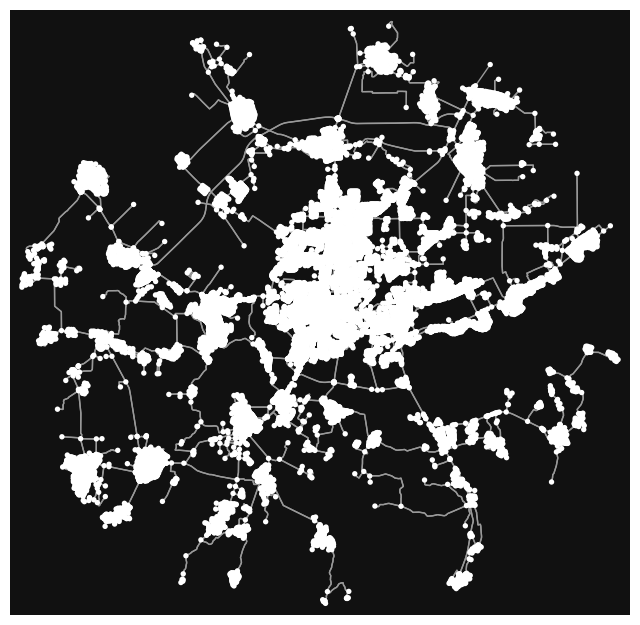

In [25]:
if __name__ == "__main__":
    osmnx_instance = OSMNX()
    cities_list = ['Краснодар','Челябинск','Тюмень','Саратов','Ульяновск','Кемерово','Балашиха','Новосибирск']
    for city in cities_list:
        filepath = f'source/{city}/layers/'
        graph = osmnx_instance.read_online_osmnx(os.path.join(filepath, 'POLYGON.shp'))
        osmnx_instance.save_graph(graph, filepath)
    
    ### нарисуем для проверки граф Краснодара
    offline_graph = osmnx_instance.read_offline_osmnx('source/Краснодар/layers/nodes.shp','source/Краснодар/layers/edges.shp')
    osmnx_instance.draw_graph(offline_graph)